In [57]:
# Importamos las librerías necesarías y fijamos la semilla
import numpy as np
import random
import scipy
from scipy.stats import uniform as spuniform
import matplotlib.pyplot as plt
import collections

from matplotlib import pyplot
import math
import statistics
import pandas as pd
import time
!pip install networkx
import networkx as nx
import os
import re
from matplotlib import colors

np.random.seed(11)

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [58]:
def timeSince(since):
    now = time.time_ns()
    s = now - since
    return s*10**(-9)

Definimos un función que entrega un grafo a partir de un número de vertices V y un a lista de aristas con sus pesos correspondientes.

In [59]:
def grafo(V,E):
    G = nx.Graph()
    G.add_nodes_from(range(V))
    G.add_edges_from([(key[0],key[1],{"weight": E[key]}) for key in list(E.keys())])
    return G 

In [60]:
def costo(ruta,distancias):
    return np.sum(distancias[ruta[i],ruta[i+1]] for i in range(len(ruta)-1))

In [61]:
def beta1(n,C): #beta lineal
    return n/C

def beta2(n,C): #beta cuadrático
    return (n**2)/C

def beta3(n,C): #beta exponencial
    return np.exp(n)/C

Se define una función que grafica el camino sobre un grafo G.

In [62]:

def plotear(G,camino):
    plt.figure()
    plt.scatter([ciudades[i][0] for i in range(len(P))],[ciudades[i][1] for i in range(len(P))], marker="o")
    for i in range(len(sigma)-1):
        plt.plot([ciudades[sigma[i]][0],ciudades[sigma[i+1]][0]],[ciudades[sigma[i]][1],ciudades[sigma[i+1]][1]],'k-')

Definimos una función que entrega un grafo regular de n vértices, todos de grado d. Los pesos de las aristas son asignados aleaoriamente entre el 1 y el 100.

In [63]:
def graforegular(d,n):
    G = nx.random_regular_graph(d,n)
    for e in G.edges():
        G[e[0]][e[1]]["weight"] = np.random.randint(1,100)
    return G

Función que realiza el Simulated Annealing dado un grafo G, configuración inicial $\sigma_0$, y sus parámetros: C, $\beta_n$ y número de pasos.

In [64]:
def SimAnn(G,sigma0,C,beta,pasos=10**4):
    inicial= sigma0[0]
    final= sigma0[-1]
    U = np.random.uniform(size = pasos) #se define las uniformes para cada paso
    sigmas = [sigma0]
    w = [nx.path_weight(G,sigma0,"weight")]
    conteo=0
    for i in range(pasos-1):
        sigma= sigmas[i] #configuración anterior
        #print(sigma)
        betan= beta(i,C) #definimos beta_n segun la función dada
        #sacamos un vecino como otra cosa mas rara
        x = random.choice(sigma[:-1])
        index = min(np.where(np.array(sigma) == x)[0])
        caminos= []
        for node in sigma[index+1:]:
            caminos.extend(list(nx.all_simple_paths(G,x,node,2)))
        add = random.choice(caminos)
        tau = sigma[:index]
        tau.extend(add)
        indexf = min(np.where(np.array(sigma) == add[-1])[0])
        tau.extend(sigma[indexf+1:])
        #remove loops
        #print(tau)
        loops = [item for item, count in collections.Counter(tau).items() if count > 1]
        while len(loops)>0:
            copia = loops[0]
            #print(copia)
            borrar1 = min(np.where(np.array(tau) == copia)[0])
            borrar2 = max(np.where(np.array(tau) == copia)[0])
            #print("1",borrar1)
            #print("2",borrar2)
            del tau[borrar1:borrar2]
            loops = [item for item, count in collections.Counter(tau).items() if count > 1]
        ws = nx.path_weight(G,sigma,"weight") #costo anterior
        wt = nx.path_weight(G,tau,"weight") #costo vecino
        dif = np.exp(-betan*(wt-ws))
        #print("betan:",betan,"ws:",ws,"wt:",wt,"dif:",dif)
        if U[i] <= min(dif,1):
            conteo +=1
            sigmas.append(tau)
            w.append(wt)
        else:
            sigmas.append(sigma)
            w.append(ws)
    #print("transiciones hechas:",conteo)
    return sigmas[len(sigmas)-1] , w[len(sigmas)-1], w , sigmas

Función auxiliar para leer archivos de formaato .stp

In [65]:
def read_stp(file_name):
    with open(file_name) as f:
        lines = f.readlines()

        sections = "Comment Graph Terminals".split()
        current_section = ""
        n, m = 0, 0
        col_s = []  # node source
        col_t = []  # node target
        col_w = []  # weight fun
        terminals = []
        for l in lines:
            if "SECTION" in l:
                current_section = l.replace("SECTION", "").strip()
            elif "END" in l:
                current_section = ""
            elif current_section == "Graph":
                if "Nodes" in l:
                    n = int(re.findall(r"\d+", l)[0])
                elif "Edges" in l:
                    m = int(re.findall(r"\d+", l)[0])
                elif "E" in l:
                    s, t, w_st = re.findall(r"\d+", l)
                    s, t, w_st = int(s), int(t), int(w_st)
                    col_s.append(s)
                    col_t.append(t)
                    col_w.append(w_st)
            elif current_section == "Terminals":
                if "T " in l:
                    terminals.append(int(re.findall(r"\d+", l)[0]))

        df_edges_G = pd.DataFrame({
            "SOURCE": col_s,
            "TARGET": col_t,
            "WEIGHT": col_w
        })

        return df_edges_G, terminals



## Implementación

Comenzamos con un grafo conexo de 4 vértices, para encontrar su solución de forma manual más fácil y verificar si el Simulated Annealing puede obtener el óptimo.

In [73]:
dic = {(0,1): 4, (0,2):7,(0,3): 10, (1,2): 2, (1,3): 5, (2,3): 2}
G  = grafo(4,dic)
p = nx.shortest_path(G,0,3,"weight") #solución por Dijkstra
ruta = [0,1,3]
pasos = 10**2
s,w,W,S = SimAnn(G,ruta,10,beta2,pasos) #solución por S.A.
print(s)
print(p)

[0, 1, 2, 3]
[0, 1, 2, 3]


Observamos el grafo y sus soluciónes:

{(0, 1): Text(0.09815341261576085, -0.18489824461931026, '4'),
 (0, 2): Text(0.019018949370788796, 0.6776184231347513, '7'),
 (0, 3): Text(-0.5510312113990173, -0.13748333224593828, '10'),
 (1, 2): Text(0.5510312113990178, 0.1374833322459384, '2'),
 (1, 3): Text(-0.019018949370788296, -0.6776184231347513, '5'),
 (2, 3): Text(-0.09815341261576035, 0.18489824461931037, '2')}

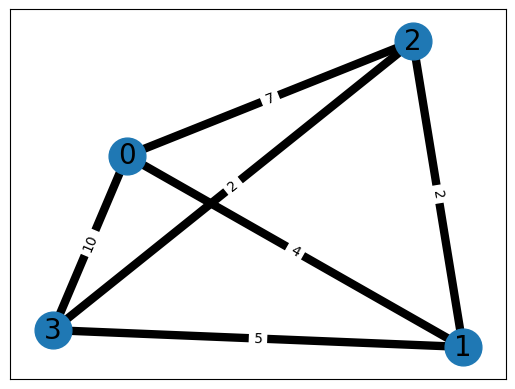

In [49]:
elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] > 0.5]
esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] <= 0.5]

pos = nx.spring_layout(G, seed=7)
nx.draw_networkx_nodes(G, pos, node_size=700)

nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif")

# edges
nx.draw_networkx_edges(G, pos, edgelist=elarge, width=6)
nx.draw_networkx_edges(
    G, pos, edgelist=esmall, width=6, alpha=0.5, edge_color="b", style="dashed"
)
edge_labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels)

{(0, 1): Text(-0.29050174399685397, -0.2677406840655219, '4'),
 (0, 2): Text(0.0010481297641470235, 0.5791849047316865, '7'),
 (0, 3): Text(0.2591995434955056, -0.1530744112027917, '10'),
 (1, 2): Text(-0.2591995434955054, 0.1530744112027917, '2'),
 (1, 3): Text(-0.0010481297641468101, -0.5791849047316865, '5'),
 (2, 3): Text(0.2905017439968542, 0.2677406840655219, '2')}

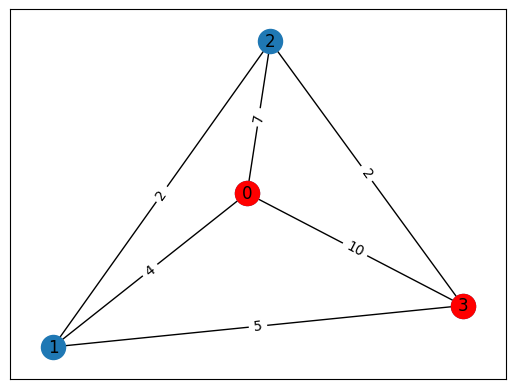

In [75]:
pos = nx.spring_layout(G)
edges = [(s[i],s[i+1]) for i in range(len(s)-1)]
edgep = [(p[i],p[i+1]) for i in range(len(p)-1)]

nx.draw_networkx_nodes(G,pos=pos)

nx.draw_networkx_nodes(G,pos=pos,nodelist=[0,3], node_color="r")

nx.draw_networkx_edges(G,pos=pos,edgelist=G.edges())
nx.draw_networkx_labels(G,pos=pos)

edge_labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels)

{(0, 1): Text(-0.2601780546931659, -0.1343659516703992, '4'),
 (0, 2): Text(0.6385550172422083, -0.1278244911797242, '7'),
 (0, 3): Text(-0.10126692806462598, 0.4841836439995856, '10'),
 (1, 2): Text(0.10126692806462584, -0.48418364399958563, '2'),
 (1, 3): Text(-0.6385550172422084, 0.12782449117972416, '5'),
 (2, 3): Text(0.26017805469316574, 0.13436595167039916, '2')}

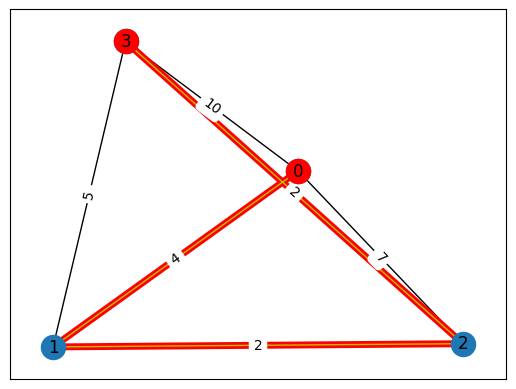

In [76]:
pos = nx.spring_layout(G)
edges = [(s[i],s[i+1]) for i in range(len(s)-1)]
edgep = [(p[i],p[i+1]) for i in range(len(p)-1)]

nx.draw_networkx_nodes(G,pos=pos)

nx.draw_networkx_nodes(G,pos=pos,nodelist=[0,3], node_color="r")

nx.draw_networkx_edges(G,pos=pos,edgelist=G.edges())
nx.draw_networkx_edges(G,pos=pos,edgelist=edges,edge_color = "r",width=5)
nx.draw_networkx_edges(G,pos=pos,edgelist=edgep,edge_color = "y")
nx.draw_networkx_labels(G,pos=pos)

edge_labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels)

Ahora implementamos Simulated Annealing en un grafo más complicado: uno conexo de 7 vértices.

In [70]:
dic = {(0,1): 2, (0,2):4,(0,3): 3, (0,5):6, (1,3): 7, (1,4): 2,(1,6): 8, (2,3): 2, (2,4):3, (2,6):6, (3,5):6, (4,5):1, (4,6):5, (5,6):3}
G  = grafo(7,dic)
ruta = [0,2,3,5,6]
pasos = 10**2
s,w,W,S = SimAnn(G,ruta,10,beta2,pasos) #solución por S.A.
p = nx.shortest_path(G,0,6,"weight") #solución por Dijkstra
print(p)
print(s)


[0, 1, 4, 5, 6]
[0, 1, 4, 5, 6]


Observamos el grafo y sus soluciónes:

{(0, 1): Text(-0.07241846320193548, 0.34574848623040616, '2'),
 (0, 2): Text(0.4688891338082407, 0.26063305532914854, '4'),
 (0, 3): Text(0.023988685534587134, 0.6812988853771728, '3'),
 (0, 5): Text(0.26017312168533596, 0.5330759908549141, '6'),
 (1, 3): Text(-0.4801746932692407, 0.31015599998118154, '7'),
 (1, 4): Text(-0.24188902941693446, -0.5126971995827926, '2'),
 (1, 6): Text(-0.3677079170122182, -0.25811655993483906, '8'),
 (2, 3): Text(0.061132903740935496, 0.22504056907992392, '2'),
 (2, 4): Text(0.29941856759324176, -0.5978126304840501, '3'),
 (2, 6): Text(0.173599679997958, -0.3432319908360967, '6'),
 (3, 5): Text(-0.14758310838196925, 0.49748350460568946, '6'),
 (4, 5): Text(0.09070255547033701, -0.3253696949582846, '1'),
 (4, 6): Text(-0.03301510442338933, -0.7454193603520465, '5'),
 (5, 6): Text(-0.03511633212494676, -0.07078905531033117, '3')}

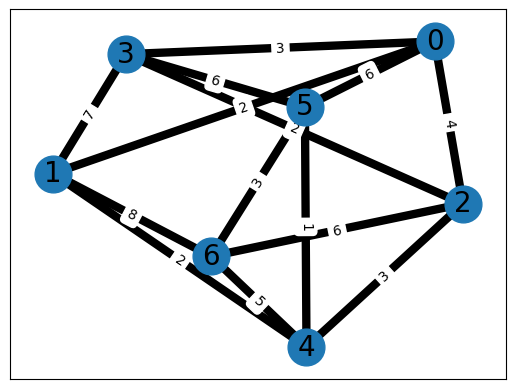

In [52]:
elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] > 0.5]
esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] <= 0.5]

pos = nx.spring_layout(G, seed=7)
nx.draw_networkx_nodes(G, pos, node_size=700)

nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif")

# edges
nx.draw_networkx_edges(G, pos, edgelist=elarge, width=6)
nx.draw_networkx_edges(
    G, pos, edgelist=esmall, width=6, alpha=0.5, edge_color="b", style="dashed"
)
edge_labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels)

{(0, 1): Text(-0.27507022044451446, 0.2751075314668418, '2'),
 (0, 2): Text(-0.16336235851362274, 0.5124270840254591, '4'),
 (0, 3): Text(-0.6024351625138054, 0.33638598893399235, '3'),
 (0, 5): Text(-0.6976207703321888, 0.09260658491562612, '6'),
 (1, 3): Text(-0.17651952725031073, 0.05586885596898592, '7'),
 (1, 4): Text(0.5754227074094901, -0.15883041738342105, '2'),
 (1, 6): Text(0.2624324356516072, -0.22966937680889035, '8'),
 (2, 3): Text(-0.06481166531941901, 0.29318840852760325, '2'),
 (2, 4): Text(0.6871305693403817, 0.07848913517519629, '3'),
 (2, 6): Text(0.3741402975824989, 0.007650175749726984, '6'),
 (3, 5): Text(-0.5990700771379851, -0.12663209058222974, '6'),
 (4, 5): Text(0.15287215752181565, -0.3413313639346367, '1'),
 (4, 6): Text(0.687009728242117, -0.38309019269414674, '5'),
 (5, 6): Text(-0.16011811423606725, -0.412170323360106, '3')}

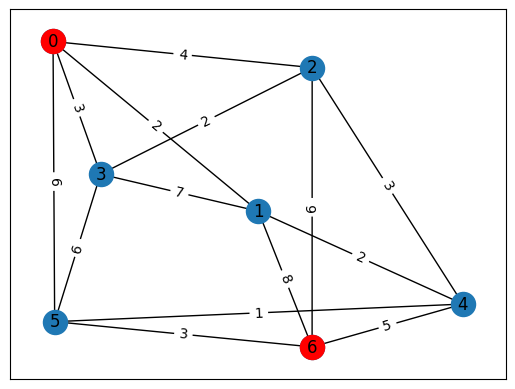

In [71]:
pos = nx.spring_layout(G)
edges = [(s[i],s[i+1]) for i in range(len(s)-1)]
edgep = [(p[i],p[i+1]) for i in range(len(p)-1)]

nx.draw_networkx_nodes(G,pos=pos)

nx.draw_networkx_nodes(G,pos=pos,nodelist=[0,6], node_color="r")

nx.draw_networkx_edges(G,pos=pos,edgelist=G.edges())
nx.draw_networkx_labels(G,pos=pos)

edge_labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels)

{(0, 1): Text(-0.18803797651550613, -0.33091460691587576, '2'),
 (0, 2): Text(0.39126200563187086, -0.4236875044312302, '4'),
 (0, 3): Text(-0.2028680854292596, -0.7103402019517968, '3'),
 (0, 5): Text(0.09305269481469593, -0.6347101059516391, '6'),
 (1, 3): Text(-0.5939833727813821, -0.15858906418434487, '7'),
 (1, 4): Text(-0.0742533374092226, 0.6104182654257881, '2'),
 (1, 6): Text(-0.29369259870528197, 0.38607206765133945, '8'),
 (2, 3): Text(-0.014683390634005145, -0.2513619616996993, '2'),
 (2, 4): Text(0.5050466447381544, 0.5176453679104336, '3'),
 (2, 6): Text(0.285607383442095, 0.293299170135985, '6'),
 (3, 5): Text(-0.3128927014511801, -0.4623845632201083, '6'),
 (4, 5): Text(0.20683733392097944, 0.30662276639002467, '1'),
 (4, 6): Text(0.2112073277531241, 0.7756538022255514, '5'),
 (5, 6): Text(-0.012601927375079938, 0.08227656861557603, '3')}

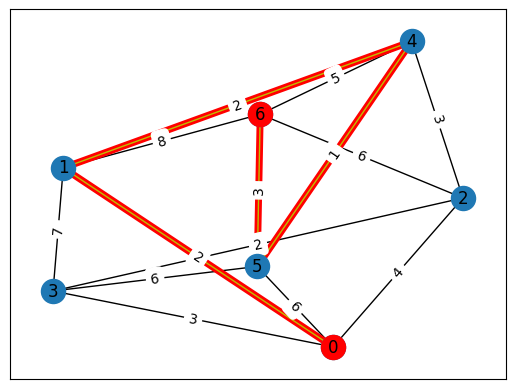

In [72]:
pos = nx.spring_layout(G)
edges = [(s[i],s[i+1]) for i in range(len(s)-1)]
edgep = [(p[i],p[i+1]) for i in range(len(p)-1)]

nx.draw_networkx_nodes(G,pos=pos)

nx.draw_networkx_nodes(G,pos=pos,nodelist=[0,6], node_color="r")

nx.draw_networkx_edges(G,pos=pos,edgelist=G.edges())
nx.draw_networkx_edges(G,pos=pos,edgelist=edges,edge_color = "r",width =5)

nx.draw_networkx_edges(G,pos=pos,edgelist=edgep,edge_color = "y")
nx.draw_networkx_labels(G,pos=pos)

edge_labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels)

## Implementación en Grafos aleatorios

Creamos un grafo regular cualquiera e implementamos Simulated Annealing para distintos valores de c y funciones $\beta$:

In [16]:
G = graforegular(30,80)
p = nx.shortest_path(G,6,25,"weight")
w = nx.path_weight(G,p,"weight")
ruta = random.choice(list(nx.all_simple_paths(G,6,25,5)))

In [17]:
c = [1,5,10,100]
pasos = [10**2, 10**3, 10**4,10**5]
i=3

s10,w10,W10,S10 = SimAnn(G,ruta,c[0],beta1,pasos[i])
s11,w11,W11,S11 = SimAnn(G,ruta,c[1],beta1,pasos[i])
s12,w12,W12,S12 = SimAnn(G,ruta,c[2],beta1,pasos[i])
s13,w13,W13,S13 = SimAnn(G,ruta,c[3],beta1,pasos[i])

s20,w20,W20,S20 = SimAnn(G,ruta,c[0],beta2,pasos[i])
s21,w21,W21,S21 = SimAnn(G,ruta,c[1],beta2,pasos[i])
s22,w22,W22,S22 = SimAnn(G,ruta,c[2],beta2,pasos[i])
s23,w23,W23,S23 = SimAnn(G,ruta,c[3],beta2,pasos[i])

s30,w30,W30,S30 = SimAnn(G,ruta,c[0],beta3,pasos[i])
s31,w31,W31,S31 = SimAnn(G,ruta,c[1],beta3,pasos[i])
s32,w32,W32,S32 = SimAnn(G,ruta,c[2],beta3,pasos[i])
s33,w33,W33,S33 = SimAnn(G,ruta,c[3],beta3,pasos[i])

/tmp/ipykernel_368/2709952426.py:37: RuntimeWarning: overflow encountered in exp
  dif = np.exp(-betan*(wt-ws))
/tmp/ipykernel_368/2709952426.py:37: RuntimeWarning: overflow encountered in double_scalars
  dif = np.exp(-betan*(wt-ws))
/tmp/ipykernel_368/1310140509.py:8: RuntimeWarning: overflow encountered in exp
  return np.exp(n)/C
/tmp/ipykernel_368/2709952426.py:37: RuntimeWarning: invalid value encountered in double_scalars
  dif = np.exp(-betan*(wt-ws))


Observamos el peso total para cada camino encontrado y se compara con el resultado encontrado por Dijkstra:

In [18]:
d = {"Método": ["Lineal", "Cuadrático", "Exponencial"] , "C=1": [nx.path_weight(G,s10,"weight"),nx.path_weight(G,s20,"weight"), nx.path_weight(G,s30,"weight")],"C=5": [nx.path_weight(G,s11,"weight"), nx.path_weight(G,s21,"weight"), nx.path_weight(G,s31,"weight")] 
    ,"C=10": [nx.path_weight(G,s12,"weight"), nx.path_weight(G,s22,"weight"), nx.path_weight(G,s32,"weight")],"C=100": [nx.path_weight(G,s13,"weight"), nx.path_weight(G,s23,"weight"), nx.path_weight(G,s33,"weight")], "Dijkstra": [nx.path_weight(G,p,"weight") for i in range(3)]}
df = pd.DataFrame(d)
df

,Método,C=1,C=5,C=10,C=100,Dijkstra
0,Lineal,15,28,38,15,15
1,Cuadrático,15,38,15,28,15
2,Exponencial,15,22,15,15,15


Observamos la evolución de los costos en cada paso para cada Simulated Annealing:

Text(0.5, 0.98, 'Comparacíon de evolución de energía con sucesión lineal para valores de C')

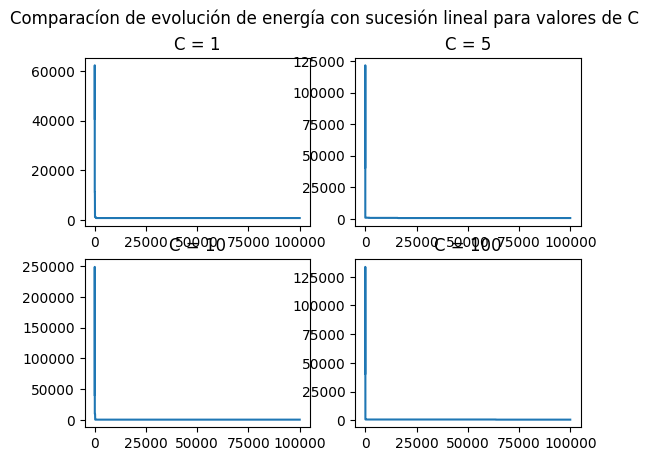

In [ ]:
X = range(pasos[i])
fig, axs = plt.subplots(2, 2)
#plt.xlim(0,100) 
#plt.ylim(20,30)
axs[0,0].plot(X,W10)
axs[0,1].plot(X,W11)
axs[1,0].plot(X,W12)
axs[1,1].plot(X,W13)
axs[0,0].set_title('C = 1')
axs[0,1].set_title('C = 5')
axs[1,0].set_title('C = 10')
axs[1,1].set_title('C = 100')

fig.suptitle("Comparacíon de evolución de energía con sucesión lineal para valores de C")
fig.tight_layout()

Text(0.5, 0.98, 'Comparación de evolución de energía con sucesión cuadrática para valores de C')

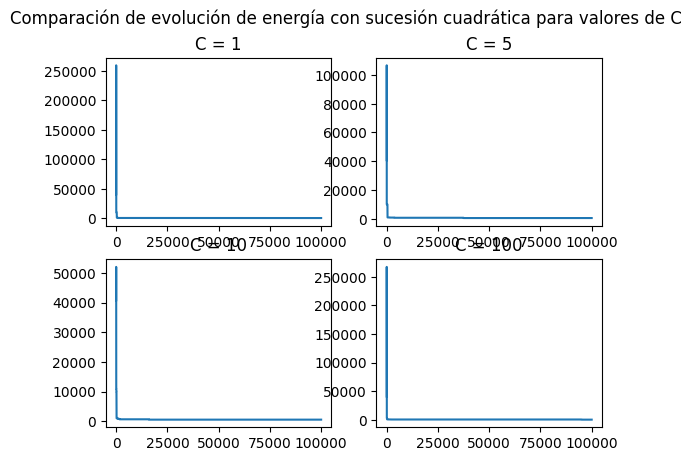

In [ ]:
X = range(pasos[i])
fig, axs = plt.subplots(2, 2)
axs[0,0].plot(X,W20)
axs[0,1].plot(X,W21)
axs[1,0].plot(X,W22)
axs[1,1].plot(X,W23)
axs[0,0].set_title('C = 1')
axs[0,1].set_title('C = 5')
axs[1,0].set_title('C = 10')
axs[1,1].set_title('C = 100')
fig.suptitle("Comparación de evolución de energía con sucesión cuadrática para valores de C")
fig.tight_layout()

Text(0.5, 0.98, 'Comparacíon de evolución de energía con sucesión exponencial para valores de C')

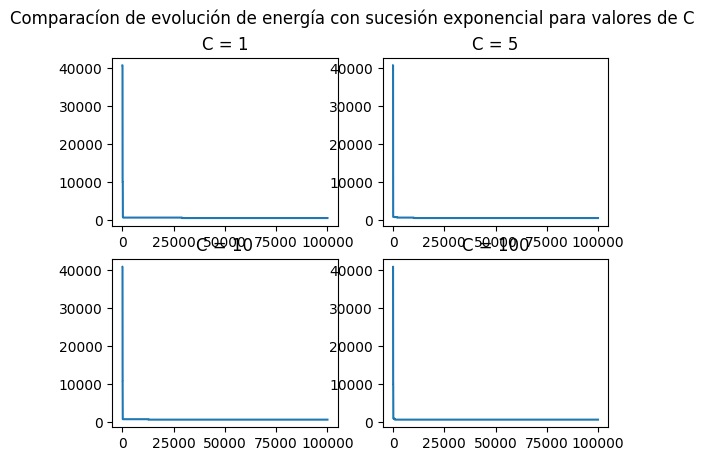

In [ ]:
X = range(pasos[i])
fig, axs = plt.subplots(2, 2)
axs[0,0].plot(X,W30)
axs[0,1].plot(X,W31)
axs[1,0].plot(X,W32)
axs[1,1].plot(X,W33)
axs[0,0].set_title('C = 1')
axs[0,1].set_title('C = 5')
axs[1,0].set_title('C = 10')
axs[1,1].set_title('C = 100')
fig.suptitle("Comparacíon de evolución de energía con sucesión exponencial para valores de C")
fig.tight_layout()

Definimos la función simulación, el cual entrega N iteraciones para cada Annealing presentado (según sus parámetros) buscando soluciones sobre un grafo regular de n nodos con grado P. En cada iteración, define un nuevo nodo inicial y nodo final para correr los 12 Annealings.

In [66]:
def simulacion(N):
    GO = time.time_ns()    
    accs = {0:0, 1:0, 2:0,3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10:0, 11:0}
    times = {0:[], 1:[], 2:[],3:[], 4:[], 5:[], 6:[], 7:[], 8:[], 9:[], 10:[], 11:[]}
    n = 50 #n nodos
    P = 15 #grado
    G = graforegular(P,n)
    c = [1,5,10,100]
    pasos = [10**2, 10**3, 10**4]
    dijkstras = []
    tiempos = []
    acc=0
    for u in range(N):
        print("Iteración:", u)
        ini = random.choice(range(n))
        fin = random.choice([h for h in range(n) if h!= ini])
        #calculamos dijkstra
        start = time.time_ns()
        p = nx.shortest_path(G,ini,fin,"weight") #dijkstra
        td = timeSince(start) #t dijkstra
        dijkstras.append(td)
        W = nx.path_weight(G,p,"weight")
        t = []
        s = []
        w = []
        ruta = random.choice(list(nx.all_simple_paths(G,ini,fin,3))) #ruta incial
        for i in range(len(c)):
            start = time.time_ns()
            s0,w0,W0,S0 = SimAnn(G,ruta,c[i],beta1,pasos[2]) #lineal
            t0 = timeSince(start)
            start = time.time_ns()
            s1,w1,W1,S1 = SimAnn(G,ruta,c[i],beta2,pasos[2]) #cuadratica
            t1 = timeSince(start)
            start = time.time_ns()
            s2,w2,W2,S2 = SimAnn(G,ruta,c[i],beta3,pasos[2]) #cuadratica
            t2 = timeSince(start)
            t.extend([t0,t1,t2])
            s.extend([s0,s1,s2])
            w.extend([w0,w1,w2])
        T = sum(t)/len(t)
        k=0
        for j in range(len(w)):
            if w[j] ==W  :
                accs[j] += 1
                times[j].append(t[j])
                if k==0:
                    acc+=1
                    k==1
        tiempos.append(T)
    for i in range(12):
        accs[i]=accs[i]/N
        times[i]=sum(times[i])/len(times[i])
    acc = acc/N
    avgtd = sum(dijkstras)/len(dijkstras)
    avgt = sum(tiempos)/len(tiempos)
    tfinal = timeSince(GO)
    return acc,avgtd, avgt,tfinal,accs,times

Implementamos 50 simulaciones y presentamos la precisión total (en cuantos problemas distintos alcanzó al menos un Annealing llegar al óptimo), el tiempo promedio que tardaron en encontrar la solución los métodos deterministas, y el tiempo promedio que tardaron los Annealings.

In [67]:
acc, avgtd, avgt, tfinal,accs,times = simulacion(50)
print("Accuracy:", acc)
print("Promedio Tiempo Dijkstra:", avgtd)
print("Promedio Tiempo S.A.:", avgt)
print("Promedio TOTAL:", tfinal)

Iteración: 0
/tmp/ipykernel_88/2709952426.py:37: RuntimeWarning: overflow encountered in exp
  dif = np.exp(-betan*(wt-ws))
/tmp/ipykernel_88/2709952426.py:37: RuntimeWarning: overflow encountered in double_scalars
  dif = np.exp(-betan*(wt-ws))
/tmp/ipykernel_88/1310140509.py:8: RuntimeWarning: overflow encountered in exp
  return np.exp(n)/C
/tmp/ipykernel_88/2709952426.py:37: RuntimeWarning: invalid value encountered in double_scalars
  dif = np.exp(-betan*(wt-ws))
Iteración: 1
Iteración: 2
Iteración: 3
Iteración: 4
Iteración: 5
Iteración: 6
Iteración: 7
Iteración: 8
Iteración: 9
Iteración: 10
Iteración: 11
Iteración: 12
Iteración: 13
Iteración: 14
Iteración: 15
Iteración: 16
Iteración: 17
Iteración: 18
Iteración: 19
Iteración: 20
Iteración: 21
Iteración: 22
Iteración: 23
Iteración: 24
Iteración: 25
Iteración: 26
Iteración: 27
Iteración: 28
Iteración: 29
Iteración: 30
Iteración: 31
Iteración: 32
Iteración: 33
Iteración: 34
Iteración: 35
Iteración: 36
Iteración: 37
Iteración: 38
Iter

Observamos el resumen de las 50 Simulaciones:

### Precisión de los métodos de Simulated Annealing

In [68]:
d = {"Método": ["Lineal", "Cuadrático", "Exponencial"] , "C=1": [accs[0], accs[1], accs[2]],"C=5": [accs[3], accs[4], accs[5]] 
    ,"C=10": [accs[6],accs[7],accs[8]],"C=100": [accs[9], accs[10],accs[11]]}
df = pd.DataFrame(d)
df

,Método,C=1,C=5,C=10,C=100
0,Lineal,0.28,0.32,0.28,0.30
1,Cuadrático,0.28,0.28,0.32,0.28
2,Exponencial,0.32,0.32,0.30,0.30



### Tiempo de ejecución promedio de los métodos de Simulated Annealing que alcanzaron el óptimo

In [69]:
d = {"Método": ["Lineal", "Cuadrático", "Exponencial"] , "C=1": [times[0], times[1], times[2]],"C=5": [times[3], times[4], times[5]] 
    ,"C=10": [times[6],times[7],times[8]],"C=100": [times[9], times[10],times[11]]}
df = pd.DataFrame(d)
df

,Método,C=1,C=5,C=10,C=100
0,Lineal,0.843950,0.884666,0.841333,0.863471
1,Cuadrático,0.848406,0.854340,0.907893,0.850005
2,Exponencial,0.910227,0.928450,0.915202,0.900737


### Anexo: Funciones de Simulated Annealing previas a la oficial

In [ ]:
def SimAnn2(G,sigma0,C,beta,pasos=10**4):
    inicial= sigma0[0]
    final= sigma0[-1]
    U = np.random.uniform(size = pasos) #se define las uniformes para cada paso
    sigmas = [sigma0]
    w = [nx.path_weight(G,sigma0,"weight")]
    conteo=0
    for i in range(pasos-1):
        sigma= sigmas[i] #configuración anterior
        #print(sigma)
        betan= beta(i,C) #definimos beta_n segun la función dada
        #sacamos un vecino como un camino cualquiera
        tau= [0]
        while tau[-1] != sigma[-1]:
            x = random.choice([a for a in G.neighbors(tau[-1]) if a not in tau])
            tau.append(x)     
        ws = nx.path_weight(G,sigma,"weight") #costo anterior
        wt = nx.path_weight(G,tau,"weight") #costo vecino
        dif = np.exp(-betan*(wt-ws))
        #print("betan:",betan,"ws:",ws,"wt:",wt,"dif:",dif)
        if U[i] <= min(dif,1):
            conteo +=1
            sigmas.append(tau)
            w.append(wt)
        else:
            sigmas.append(sigma)
            w.append(ws)
    print("transiciones hechas:",conteo)
    return sigmas[len(sigmas)-1] , w[len(sigmas)-1], w , sigmas



In [ ]:
def SimAnn3(G,sigma0,C,beta,pasos=10**4):
    inicial= sigma0[0]
    final= sigma0[-1]
    U = np.random.uniform(size = pasos) #se define las uniformes para cada paso
    sigmas = [sigma0]
    w = [nx.path_weight(G,sigma0,"weight")]
    conteo=0
    for i in range(pasos-1):
        sigma= sigmas[i] #configuración anterior
        #print(sigma)
        betan= beta(i,C) #definimos beta_n segun la función dada
        #sacamos un vecino
        if len(sigma)==2:
            tau = random.choice(list(nx.all_simple_paths(G, source=sigma[0], target=sigma[-1])))
        else:
            x =np.random.randint(1,len(sigma)-1) #elegir nodo a sacar
            v = sigma[x-1]
            V = sigma[x+1]
            H = G.subgraph([n for n in list(G.nodes()) if n not in sigma].extend([v,V]))
            caminos = list(nx.all_simple_paths(H, source=v, target=V))
            if len(caminos)==1:
                t= caminos[0]
            else:
                t = random.choice(caminos)
            tau = sigma[:x]
            tau.extend(t[1:-1])
            tau.extend(sigma[x+1:])
        ws = nx.path_weight(G,sigma,"weight") #costo anterior
        wt = nx.path_weight(G,tau,"weight") #costo vecino
        dif = np.exp(-betan*(wt-ws))
        #print("betan:",betan,"ws:",ws,"wt:",wt,"dif:",dif)
        if U[i] <= min(dif,1):
            conteo +=1
            sigmas.append(tau)
            w.append(wt)
        else:
            sigmas.append(sigma)
            w.append(ws)
        
    print("transiciones hechas:",conteo)
    return sigmas[len(sigmas)-1] , w[len(sigmas)-1], w , sigmas



<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=45a688e7-b6e2-4e4a-b3a9-c39f5b699a07' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>